# Vector Autoregressive Moving Average: VARMA(p,q)
The system of equations for a 2-dimensional VAR(1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\phi_{ii,l}$ captures the influence of the $l$th lag of variable $y_i$ on itself,<br>
the coefficient $\phi_{ij,l}$ captures the influence of the $l$th lag of variable $y_j$ on $y_i$.<br>
Most importantly, $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are white noise processes that may be correlated.<br>

In a <strong>VARMA(p,q)</strong> model we give the error terms $\varepsilon_t$ a moving average representation of order $q$.


## Formulation
We've seen that an autoregressive moving average ARMA(p,q) model is described by the following:

&nbsp;&nbsp;&nbsp;&nbsp; $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \theta_{1}\varepsilon_{t-1} + \theta_{2}\varepsilon_{t-2} + \dots + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t}$

A $K$-dimensional VARMA model of order $(p,q)$ considers each variable $y_K$ in the system.<br>

For example, the system of equations for a 2-dimensional VARMA(1,1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \theta_{11,1}\varepsilon_{1,t-1} + \theta_{12,1}\varepsilon_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \theta_{21,1}\varepsilon_{1,t-1} + \theta_{22,1}\varepsilon_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\theta_{ii,l}$ captures the influence of the $l$th lag of error $\varepsilon_i$ on itself,<br>
the coefficient $\theta_{ij,l}$ captures the influence of the $l$th lag of error $\varepsilon_j$ on $\varepsilon_i$,<br>
and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are residual white noise.<br>


The general steps involved in building a VARMA model are:
* Examine the data
* Visualize the data
* Test for stationarity
* If necessary, transform the data to make it stationary
* Select the appropriate <em>p</em> and <em>q</em> orders
* Instantiate the model and fit it to a training set
* If necessary, invert the earlier transformation
* Evaluate model predictions against a known test set
* Forecast the future

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from pylab import rcParams

rcParams['figure.figsize'] = 20, 6
rcParams['axes.grid'] = True

In [2]:
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

# Load datasets
df = pd.read_csv('../meta/M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('../meta/PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [3]:
df = df.join(sp)
df = df.dropna()
df.shape
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


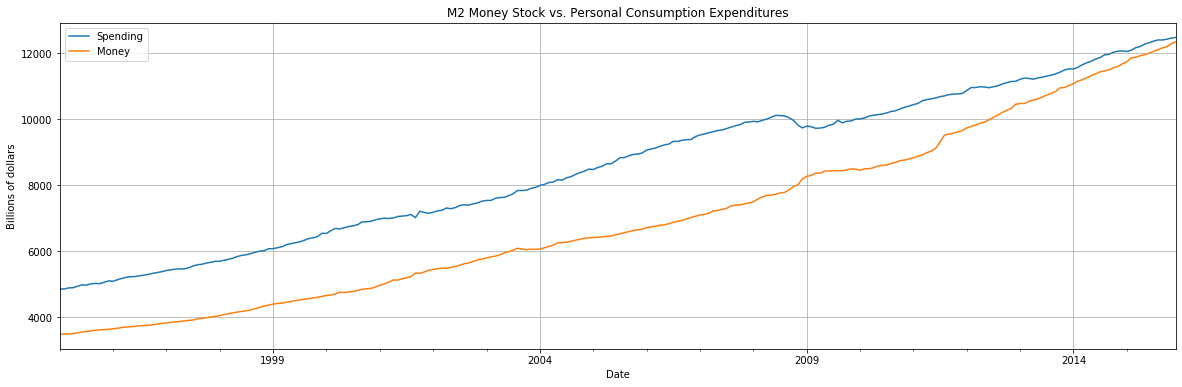

In [4]:
title = 'M2 Money Stock vs. Personal Consumption Expenditures'
ylabel='Billions of dollars'
xlabel=''

ax = df['Spending'].plot(legend=True)
ax.set(xlabel=xlabel, ylabel=ylabel,title=title)
df['Money'].plot(legend=True);

## Test for stationarity, perform any necessary transformations

In [5]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string(), '\n')          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
    return out

In [6]:
auto_arima(df['Money'],maxiter=1000)

ARIMA(maxiter=1000, order=(1, 2, 1), scoring_args={}, with_intercept=False)

In [7]:
auto_arima(df['Spending'],maxiter=1000)

ARIMA(maxiter=1000, order=(1, 1, 2), scoring_args={})

It looks like a VARMA(1,2) model is recommended. Note that the $d$ term (2 for Money, 1 for Spending) is about to be addressed by transforming the data to make it stationary. As before we'll apply a second order difference.

In [8]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


**Train/test/split**

In [9]:
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

## Fit the VARMA(1,2) Model

In [10]:
model = VARMAX(train, order=(1,2), trend='c').fit(maxiter=1000, disp=False)
model.summary()

D:\Users\Ritvik\Anaconda3\envs\ailab\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.603
,+ intercept,AIC,4607.206
Date:,"Fri, 06 Nov 2020",BIC,4666.235
Time:,09:57:17,HQIC,4630.996
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"68.08, 28.16",Jarque-Bera (JB):,"556.20, 123.98"
Prob(Q):,"0.00, 0.92",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.69, 2.87",Skew:,"1.32, -0.34"


## Predict the next 12 values
Unlike the VAR model we used in the previous section, the VARMAX <tt>.forecast()</tt> function won't require that we pass in a number of previous observations, and it will provide an extended DateTime index.

In [11]:
df_forecast = model.forecast(12)
df_forecast

D:\Users\Ritvik\Anaconda3\envs\ailab\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


,Money,Spending
2015-01-01,-13.281861,39.344715
2015-02-01,-11.455247,-6.184248
2015-03-01,1.683158,0.199094
2015-04-01,-1.624029,-0.425024
2015-05-01,1.012199,0.463433
2015-06-01,-0.371582,0.046191
2015-07-01,0.444934,0.301760
2015-08-01,-0.019660,0.157933
2015-09-01,0.247611,0.240954
2015-10-01,0.094369,0.193402


## Invert the Transformation
Remember that the forecasted values represent second-order differences. To compare them to the original data we have to roll back each difference. To roll back a first-order difference we take the most recent value on the training side of the original series, and add it to a cumulative sum of forecasted values. When working with second-order differences we first must perform this operation on the most recent first-order difference.

Here we'll use the <tt>nobs</tt> variable we defined during the train/test/split step.

In [12]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [13]:
df_forecast

,Money,Spending,Money1d,Spending1d,MoneyForecast,SpendingForecast
2015-01-01,-13.281861,39.344715,65.318139,49.944715,11656.818139,12101.344715
2015-02-01,-11.455247,-6.184248,53.862892,43.760467,11645.362892,12095.160467
2015-03-01,1.683158,0.199094,55.546050,43.959561,11647.046050,12095.359561
2015-04-01,-1.624029,-0.425024,53.922020,43.534537,11645.422020,12094.934537
2015-05-01,1.012199,0.463433,54.934219,43.997970,11646.434219,12095.397970
2015-06-01,-0.371582,0.046191,54.562637,44.044161,11646.062637,12095.444161
2015-07-01,0.444934,0.301760,55.007571,44.345921,11646.507571,12095.745921
2015-08-01,-0.019660,0.157933,54.987911,44.503854,11646.487911,12095.903854
2015-09-01,0.247611,0.240954,55.235522,44.744808,11646.735522,12096.144808
2015-10-01,0.094369,0.193402,55.329891,44.938210,11646.829891,12096.338210


In [14]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]],axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11656.818139,12101.344715
2015-02-01,11852.4,12082.4,11645.362892,12095.160467
2015-03-01,11868.8,12158.3,11647.046050,12095.359561
2015-04-01,11916.1,12193.8,11645.422020,12094.934537
2015-05-01,11947.6,12268.1,11646.434219,12095.397970
2015-06-01,11993.1,12308.3,11646.062637,12095.444161
2015-07-01,12045.3,12355.4,11646.507571,12095.745921
2015-08-01,12096.8,12394.0,11646.487911,12095.903854
2015-09-01,12153.8,12392.8,11646.735522,12096.144808


## Plot the results

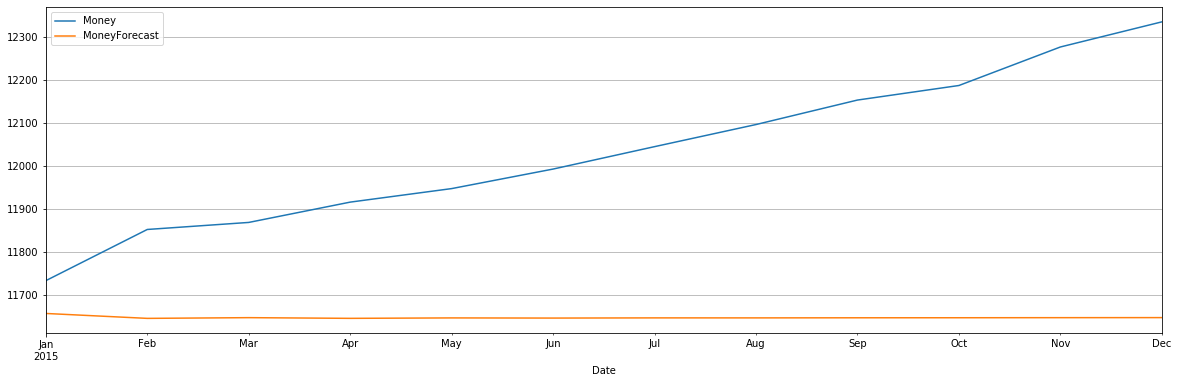

In [15]:
df['Money'][-nobs:].plot(legend=True)
df_forecast['MoneyForecast'].plot(legend=True);

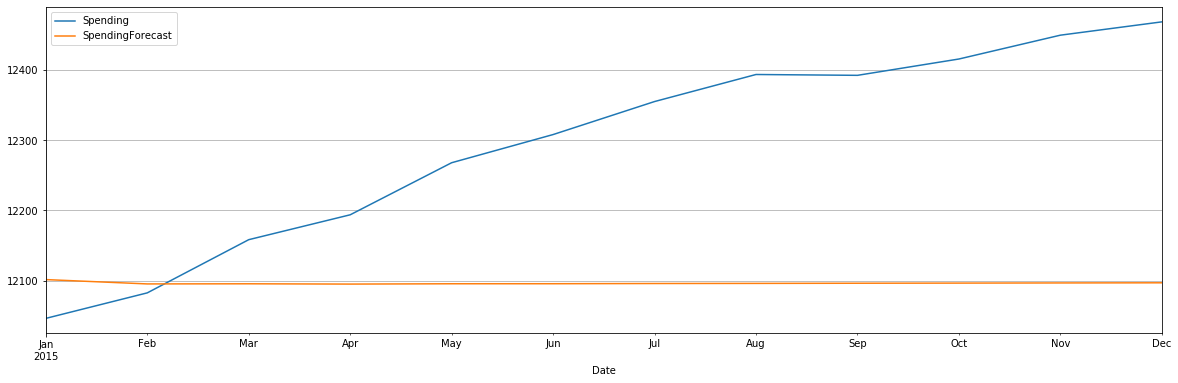

In [16]:
df['Spending'][-nobs:].plot(legend=True)
df_forecast['SpendingForecast'].plot(legend=True);

In [17]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

Money VAR(5) RMSE: 424.806


In [18]:
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Spending VAR(5) RMSE: 241.912


Clearly these results are less accurate than our earlier VAR(5) model. Still, this tells us something!
## Let's compare these results to individual ARMA(1,2) models

In [19]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults

### Money

In [20]:
model = ARMA(train['Money'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1117.710
Method:                       css-mle   S.D. of innovations             26.214
Date:                Fri, 06 Nov 2020   AIC                           2245.421
Time:                        09:57:19   BIC                           2262.782
Sample:                    03-01-1995   HQIC                          2252.418
                         - 12-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1814      0.029      6.302      0.000       0.125       0.238
ar.L1.Money    -0.3569      0.293     -1.217      0.223      -0.931       0.218
ma.L1.Money    -0.4087      0.260     -1.572      0.116      -0.918       0.101
ma.L2.Money    -0.5912      0.260     -2.278      0.023      -1.100      -0.083
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.8023           +0.0000j            2.8023            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.6913           +0.0000j            1.6913            0.5000
-----------------------------------------------------------------------------
"""

In [21]:
start=len(train)
end=len(train)+len(test)-1
z1 = results.predict(start=start, end=end).rename('Money')
z1 = pd.DataFrame(z1)

In [22]:
z1

,Money
2015-01-01,-14.499055
2015-02-01,-10.946985
2015-03-01,4.152604
2015-04-01,-1.235745
2015-05-01,0.687109
2015-06-01,0.000931
2015-07-01,0.245796
2015-08-01,0.158415
2015-09-01,0.189598
2015-10-01,0.178470


### Invert the Transformation, Evaluate the Forecast

In [23]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z1['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()

# Now build the forecast values from the first difference set
z1['MoneyForecast'] = df['Money'].iloc[-nobs-1] + z1['Money1d'].cumsum()

In [24]:
z1

,Money,Money1d,MoneyForecast
2015-01-01,-14.499055,64.100945,11734.200945
2015-02-01,-10.946985,53.153960,11787.354905
2015-03-01,4.152604,57.306565,11844.661470
2015-04-01,-1.235745,56.070820,11900.732290
2015-05-01,0.687109,56.757929,11957.490219
2015-06-01,0.000931,56.758860,12014.249079
2015-07-01,0.245796,57.004656,12071.253735
2015-08-01,0.158415,57.163072,12128.416807
2015-09-01,0.189598,57.352669,12185.769476
2015-10-01,0.178470,57.531139,12243.300615


In [25]:
RMSE3 = rmse(df['Money'][-nobs:], z1['MoneyForecast'])

print(f'Money VARMA(1,2) RMSE: {RMSE1:.3f}')
print(f'Money  ARMA(1,2) RMSE: {RMSE3:.3f}')

Money VARMA(1,2) RMSE: 424.806
Money  ARMA(1,2) RMSE: 32.236


### Personal Spending

In [26]:
model = ARMA(train['Spending'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Spending   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1182.411
Method:                       css-mle   S.D. of innovations             34.661
Date:                Fri, 06 Nov 2020   AIC                           2374.823
Time:                        09:57:20   BIC                           2392.184
Sample:                    03-01-1995   HQIC                          2381.820
                         - 12-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0856      0.245      0.350      0.726      -0.394       0.565
ar.L1.Spending    -0.3403      0.511     -0.666      0.505      -1.342       0.661
ma.L1.Spending    -0.6451      0.521     -1.237      0.216      -1.667       0.377
ma.L2.Spending    -0.2139      0.485     -0.441      0.659      -1.165       0.737
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.9387           +0.0000j            2.9387            0.5000
MA.1            1.1281           +0.0000j            1.1281            0.0000
MA.2           -4.1438           +0.0000j            4.1438            0.5000
-----------------------------------------------------------------------------
"""

In [27]:
start=len(train)
end=len(train)+len(test)-1
z2 = results.predict(start=start, end=end).rename('Spending')
z2 = pd.DataFrame(z2)
z2

,Spending
2015-01-01,33.555817
2015-02-01,-3.338242
2015-03-01,1.250708
2015-04-01,-0.310836
2015-05-01,0.220532
2015-06-01,0.039716
2015-07-01,0.101245
2015-08-01,0.080307
2015-09-01,0.087432
2015-10-01,0.085008


### Invert the Transformation, Evaluate the Forecast

In [28]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z2['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + z2['Spending'].cumsum()

# Now build the forecast values from the first difference set
z2['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + z2['Spending1d'].cumsum()

In [29]:
z2

,Spending,Spending1d,SpendingForecast
2015-01-01,33.555817,44.155817,12106.155817
2015-02-01,-3.338242,40.817575,12146.973392
2015-03-01,1.250708,42.068283,12189.041675
2015-04-01,-0.310836,41.757447,12230.799121
2015-05-01,0.220532,41.977978,12272.777100
2015-06-01,0.039716,42.017694,12314.794794
2015-07-01,0.101245,42.118939,12356.913733
2015-08-01,0.080307,42.199246,12399.112979
2015-09-01,0.087432,42.286678,12441.399657
2015-10-01,0.085008,42.371686,12483.771343


In [30]:
RMSE4 = rmse(df['Spending'][-nobs:], z2['SpendingForecast'])

print(f'Spending VARMA(1,2) RMSE: {RMSE2:.3f}')
print(f'Spending  ARMA(1,2) RMSE: {RMSE4:.3f}')

Spending VARMA(1,2) RMSE: 241.912
Spending  ARMA(1,2) RMSE: 52.334


<strong>CONCLUSION:</strong> It looks like the VARMA(1,2) model did a relatively poor job compared to simpler alternatives. This tells us that there is little or no interdepence between Money Stock and Personal Consumption Expenditures, at least for the timespan we investigated. This is helpful! By fitting a model and getting poor results we know more about the data than we did before.